In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

# CRF model

We consider the input image $I$ to be a graph $V$ with each node $v$ carrying pixel data (RGB). Then we can see about downsampling using e.g. SLIC.

We want to classify each node $v$ as foreground ($1$) or background ($0$). For this, we will use a conditional random field (CRF) model specified over the nodes: the label likelihood factors as logistic regression given a latent variable $Z_v$ at node $v$:
$$
    p(l_v|Z_v;\theta) = g(\theta^\intercal Z_v)\quad
    \text{where}\ g(u) = \frac{e^u}{e^u + 1}
$$
and $\theta$ is a parameter vector we learn over the set of examples.

The data likelihood is given by
$$
    \mathcal L(\theta; I) = \log\left(
        \sum_Z p(l|Z;\theta) p(Z|I)
    \right) =
    \log\left(\sum_Z
    \left[ \prod_{v\in V} 
            g(\theta^\intercal Z_v)\right] p(Z|I)
    \right)
$$

In [2]:
import matplotlib.pyplot as plt
import cv2

import glob

IMAGE_FOLDER = "data/train/images"
MASKS_FOLDER = "data/train/masks"

IMAGES = glob.glob(os.path.join(IMAGE_FOLDER, "*.jpg"))

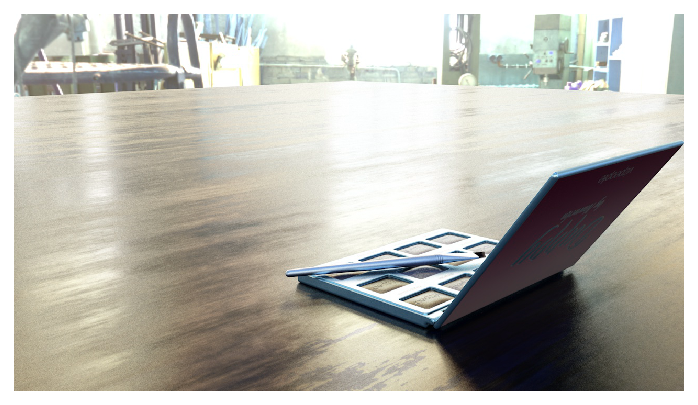

In [3]:
## Load an image
img = cv2.imread(IMAGES[0], cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

## Smart downsampling with SLIC

We define a SLIC superpixel model with $N=400$ components.

In [4]:
from fast_slic.avx2 import SlicAvx2

In [5]:
slic = SlicAvx2(num_components=400, compactness=10)

In [6]:
assignments = slic.iterate(img)

In [7]:
from skimage import color
from skimage.segmentation import mark_boundaries

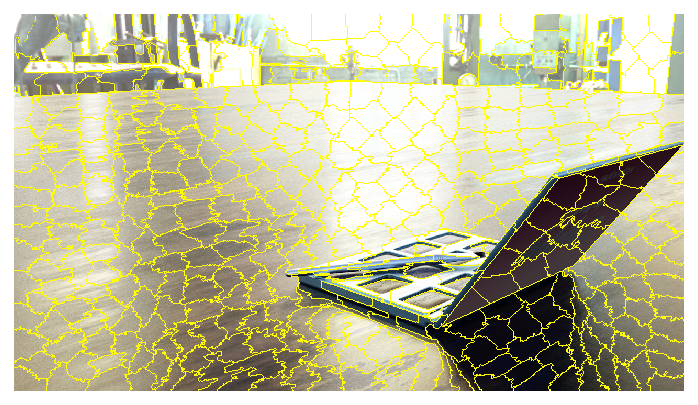

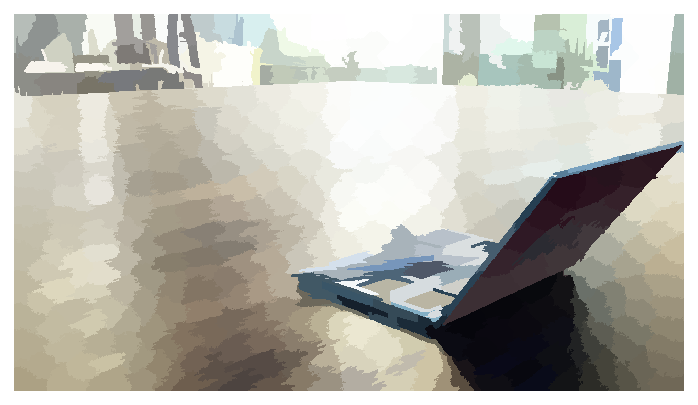

In [8]:
img_slic_boundaries = mark_boundaries(img, assignments)
img_slic = color.label2rgb(assignments, img, kind='avg')

plt.figure()
plt.imshow(img_slic_boundaries)
plt.axis('off')

plt.figure()
plt.imshow(img_slic)
plt.axis('off');

Now, we want to infer the labels of the SLIC cluster graph nodes.

In [9]:
## Recover the neighbors of each node
from utils import get_slic_graph

In [10]:
nodes, neighbors = get_slic_graph(slic, assignments)

In [11]:
print("NODE0:", nodes[0])

for n in neighbors[0]:
    print(nodes[n])

NODE0: {'number': 0, 'yx': (25.0, 17.0), 'color': (152.0, 121.0, 131.0), 'num_members': 642}
{'number': 1, 'yx': (25.0, 110.0), 'color': (139.0, 120.0, 131.0), 'num_members': 921}
{'number': 61, 'yx': (128.0, 87.0), 'color': (109.0, 129.0, 133.0), 'num_members': 1020}


## Conditionally deterministic $Z$

Let's define the latent variable $Z$ to be a deterministic feature function of the node data $X$.

An easy choice to recover image data is to say that for all nodes $v$, $Z_v$ is the graph Laplacian at $v$.